In [1]:
import Flux
using Flux.Tracker, Statistics, DelimitedFiles
using Flux.Tracker: Params, gradient, update!
using Flux: gpu, Dense, relu, Chain, ADAM, Descent, params, throttle, Dropout, @epochs, testmode!

using Base.Iterators: repeated

using Plots, DataFrames, DataFramesMeta, ExcelFiles, MLDataUtils, HDF5, ProgressMeter, LaTeXStrings
pyplot() # using the pyplot backend

using BSON: @save, @load
using NNlib, Polynomials

include("flux_functions.jl")

loss_tg_sc_d (generic function with 1 method)

# Look at last results

loaded

Features in X_ arrays are
["sio2", "al2o3", "na2o", "k2o", "nbot", "ifsm", "ifst", "ap", "b", "T", "Sc", "tg"]

Shape of X train and valid is
(12, 1153)
Size of Raman datasets
(4, 31)
(850, 31)
(4, 14)
(850, 14)


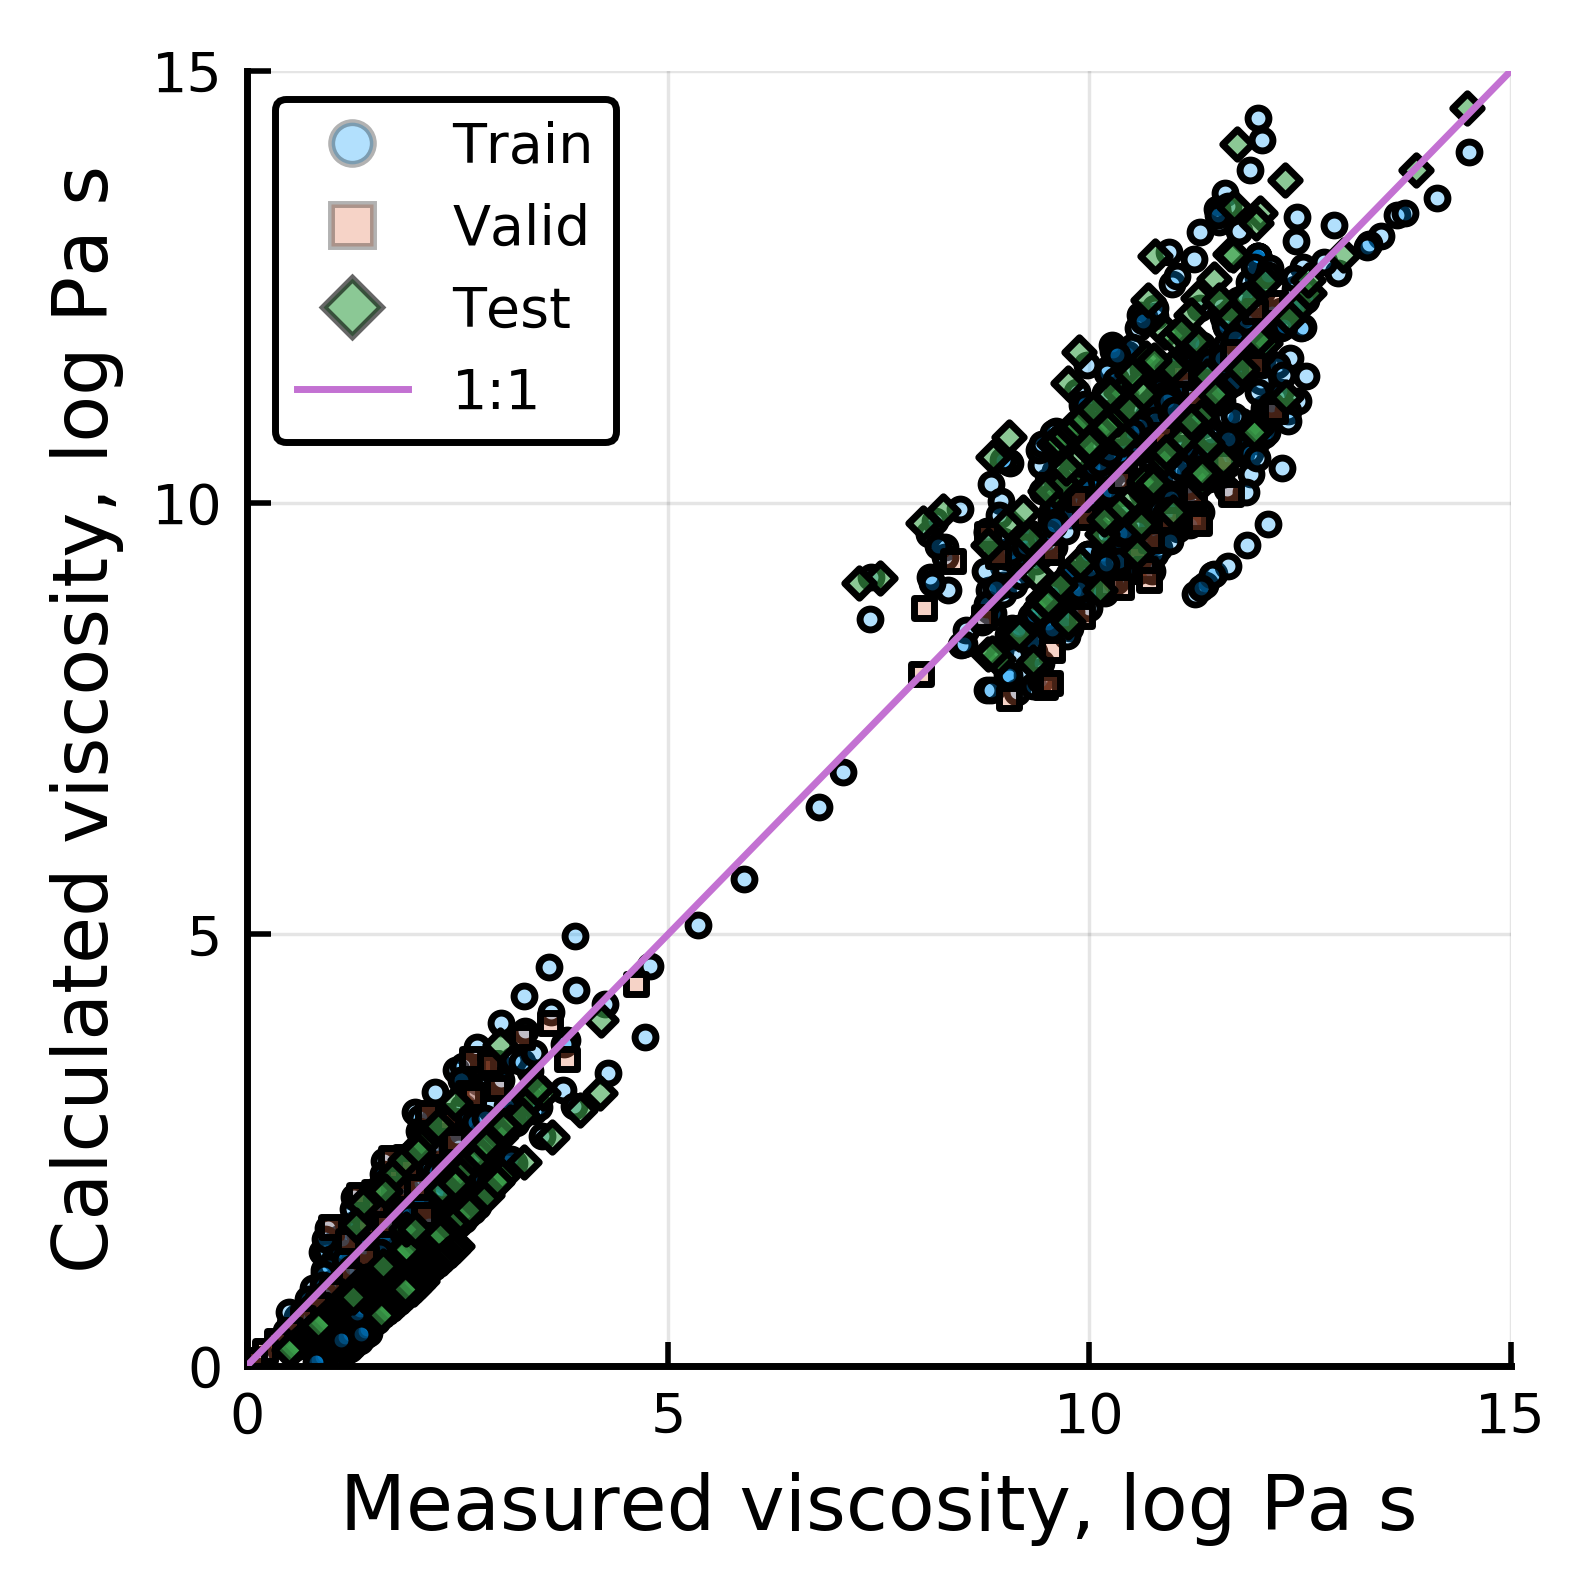

0.7559969312542829 (tracked)
0.7257445449199301 (tracked)
0.7971484556959761 (tracked)

In [6]:
#
# Load data
#
datas = load_data("./data/DataSet_0p10val.hdf5","./data/NKAS_DataSet.hdf5","./data/NKAS_density.hdf5")

#
# Load network
#
@load "./model/Ae_test.bson" Ae
@load "./model/nnr_test.bson" nnr
@load "./model/nns_test.bson" nns
testmode!(nnr)
testmode!(nns)

x_train_, y_train_, T_train_, ap_train_, b_train_, sc_train_, tg_train_ = prepare_data(datas["X_train"],datas["y_train"])
x_valid_, y_valid_, T_valid_, ap_valid_, b_valid_, sc_valid_, tg_valid_ = prepare_data(datas["X_valid"],datas["y_valid"])
x_test_, y_test_, T_test_, ap_test_, b_test_, sc_test_, tg_test_ = prepare_data(datas["X_test"],datas["y_test"])

p1 = scatter(y_train_[:],
    ag(x_train_,T_train_,ap_train_, b_train_,nns,Ae).data[:],
    label="Train",legend=:topleft,m=(3,0.3, :auto),
xlabel="Measured viscosity, log Pa s",
ylabel="Calculated viscosity, log Pa s",
xlim=(0,15),
ylim=(0,15),
dpi=500,
size=(300,300))

scatter!(y_valid_[:],
    ag(x_valid_,T_valid_,ap_valid_, b_valid_,nns,Ae).data[:],label="Valid",m=(3,0.3, :auto))

scatter!(vec(y_test_),ag(x_test_,T_test_,ap_test_,b_test_, nns, Ae).data[:],label="Test",m=(:diamond,3,0.6))

plot!([0.,16.],[0.,16.],label="1:1")
show()
savefig("./figures/KNAS_visco.png")

println(loss_n(x_train_,T_train_,ap_train_, b_train_,y_train_,nns,Ae))
println(loss_n(x_valid_,T_valid_,ap_valid_, b_valid_,y_valid_,nns,Ae))
print(loss_n(x_test_,T_test_,ap_test_,b_test_,y_test_,nns,Ae))

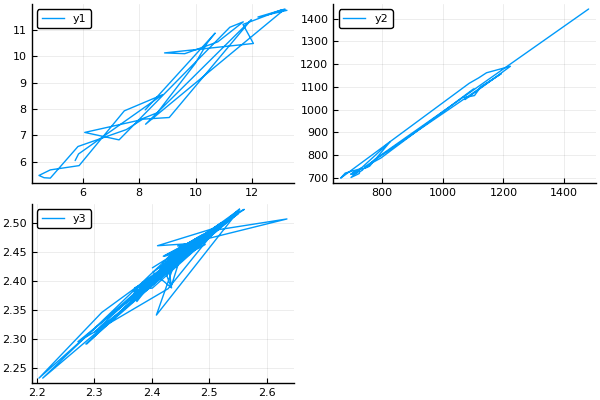

In [7]:
plot([datas["X_entropy_train"][11,:],datas["X_entropy_train"][12,:],datas["y_density_train"]'], # x values
            [ScTg(datas["X_entropy_train"],nns).data[:],tg(datas["X_entropy_train"],nns).data[:],density(datas["X_density_train"],nns).data[:]], # y values
            layout=3)

# Size of dataset analysis

In [12]:
prefix= ["_0p10val","_0p20val","_0p30val","_0p40val","_0p50val","_0p60val","_0p70val","_0p80val"]
suffix = ["_1","_2","_3","_4","_5","_6"]

# variable to record the results
total_size_train = zeros(length(prefix))
compo_size_train = zeros(length(prefix))
error_size_train = zeros(length(prefix),length(suffix))
error_size_valid = zeros(length(prefix),length(suffix))
error_size_test = zeros(length(prefix),length(suffix))

for j = 1:length(prefix) # main loop: between datasets

    # Load the good dataset
    dataset_name = "./data/DataSet"*prefix[j]*".hdf5"
    datas = load_data(dataset_name,"./data/NKAS_DataSet.hdf5", verbose = false)
    
    # Prepare the data
    x_train_, y_train_, T_train_, ap_train_, b_train_, sc_train_, tg_train_ = prepare_data(datas["X_train"],datas["y_train"])
    x_valid_, y_valid_, T_valid_, ap_valid_, b_valid_, sc_valid_, tg_valid_ = prepare_data(datas["X_valid"],datas["y_valid"])
    x_test_, y_test_, T_test_, ap_test_, b_test_, sc_test_, tg_test_ = prepare_data(datas["X_test"],datas["y_test"])
    
    # This is for saving predicted y values
    y_train_pred = zeros(length(T_train_),length(suffix))
    y_valid_pred = zeros(length(T_valid_),length(suffix))
    y_test_pred = zeros(length(T_test_),length(suffix))

    for i = 1:length(suffix) # subloop: between each different training on one dataset
        
        # Loading the network and freezing dropout
        @load "/home/charles/Desktop/exp_size/Ae"*prefix[j]*suffix[i]*".bson" Ae
        @load "/home/charles/Desktop/exp_size/nnr"*prefix[j]*suffix[i]*".bson" nnr
        @load "/home/charles/Desktop/exp_size/nns"*prefix[j]*suffix[i]*".bson" nns
        testmode!(nnr)
        testmode!(nns)

        # predictions
        #error_size_train[j,i] = loss_n(x_train_,T_train_,ap_train_, b_train_,y_train_,nns,Ae).data
        #error_size_valid[j,i] = loss_n(x_valid_,T_valid_,ap_valid_, b_valid_,y_valid_,nns,Ae).data
        #error_size_test[j,i]  = loss_n(x_test_,T_test_,ap_test_,b_test_,y_test_,nns,Ae).data
        
        error_size_train[j,i] = loss_n_myega(x_train_,T_train_,y_train_,nns,Ae).data
        error_size_valid[j,i] = loss_n_myega(x_valid_,T_valid_,y_valid_,nns,Ae).data
        error_size_test[j,i]  = loss_n_myega(x_test_,T_test_,y_test_,nns,Ae).data

    end

    # saving in output variables
    total_size_train[j] = length(T_train_)
    compo_size_train[j] = size(unique(x_train_,dims=2),2)

end

## Figure

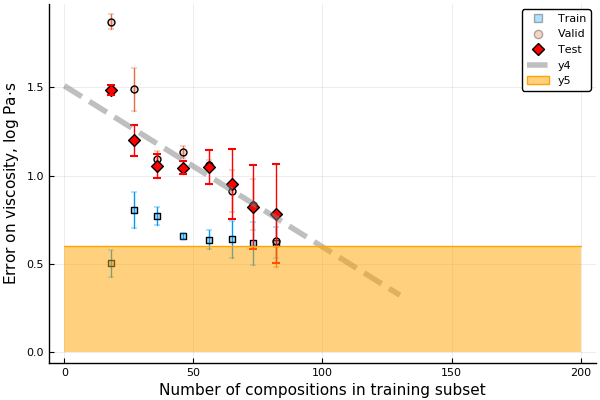

In [13]:
# Plot error data (different subsets)

scatter(compo_size_train,mean(error_size_train,dims=2),yerr=std(error_size_train,dims=2),
        m=(:square,5,0.3),
        label="Train")
scatter!(compo_size_train,mean(error_size_valid,dims=2),yerr=std(error_size_valid,dims=2),
        m=(:circle,5,0.3),
        label="Valid")

scatter!(compo_size_train,mean(error_size_test,dims=2),yerr=std(error_size_test,dims=2),
    m=(:diamond,6),
    xlabel="Number of compositions in training subset",
    ylabel=L"Error on viscosity, log Pa$\cdot$s",
    label="Test",
    color=:red,
    ylim=(0,))

# Plot general trend
X_interp = collect(0:10:130)
plot!(X_interp,polyval(polyfit(compo_size_train,vec(mean(error_size_test,dims=2)),1), X_interp),
        line=(:dash,:grey,4.0,0.5))

# Plot target
plot!([0,200],[0.6,0.6],ribbon=(0.6,0.),color=:orange)

In [15]:
Float32.(h5read("./data/NKAS_density.hdf5","y_density_train"))

1×107 Array{Float32,2}:
 2.401  2.511  2.5224  2.462  2.445  2.465  …  2.4644  2.55  2.5507  2.4273

In [18]:
h5read("./data/DataSet_0p10val.hdf5","X_columns")

12-element Array{String,1}:
 "sio2" 
 "al2o3"
 "na2o" 
 "k2o"  
 "nbot" 
 "ifsm" 
 "ifst" 
 "ap"   
 "b"    
 "T"    
 "Sc"   
 "tg"   

In [ ]:
# Keeping only the best

# Network Architecture

In [71]:
# List of networks
list_Ae = filter(x->occursin("Ae",x), readdir("./model/architecture_exp"))
list_nnr = filter(x->occursin("nnr",x), readdir("./model/architecture_exp"))
list_nns = filter(x->occursin("nns",x), readdir("./model/architecture_exp"))

# Load the good dataset
datas = load_data("./data/DataSet_0p10val.hdf5","./data/NKAS_DataSet.hdf5", verbose = false)

# Prepare the data
x_train_, y_train_, T_train_, ap_train_, b_train_, sc_train_, tg_train_ = prepare_data(datas["X_train"],datas["y_train"])
x_valid_, y_valid_, T_valid_, ap_valid_, b_valid_, sc_valid_, tg_valid_ = prepare_data(datas["X_valid"],datas["y_valid"])
x_test_, y_test_, T_test_, ap_test_, b_test_, sc_test_, tg_test_ = prepare_data(datas["X_test"],datas["y_test"])

# This is for saving predicted y values
y_train_pred = zeros(length(T_train_),length(suffix))
y_valid_pred = zeros(length(T_valid_),length(suffix))
y_test_pred = zeros(length(T_test_),length(suffix))

# This is for saving the architecture
arch = zeros(length(list_Ae),2) # rows: nb_experiments; cols: nb neurons and layers

# This is for saving the errors
errors_arch_train_valid_test = zeros(length(list_Ae),3)

# Start the loop
for i = 1:length(list_Ae)
    arch[i,1] = parse(Int,split(list_Ae[i],"_")[2])
    arch[i,2] = parse(Int,split(list_Ae[i],"_")[4])
    
    @load "./model/architecture_exp/"*list_Ae[i] Ae
    @load "./model/architecture_exp/"*list_nnr[i] nnr
    @load "./model/architecture_exp/"*list_nns[i] nns
    testmode!(nnr)
    testmode!(nns)

    # predictions
    errors_arch_train_valid_test[i,1] = loss_n(x_train_,T_train_,ap_train_, b_train_,y_train_,nns,Ae).data
    errors_arch_train_valid_test[i,2] = loss_n(x_valid_,T_valid_,ap_valid_, b_valid_,y_valid_,nns,Ae).data
    errors_arch_train_valid_test[i,3]  = loss_n(x_test_,T_test_,ap_test_,b_test_,y_test_,nns,Ae).data
end


## Figure

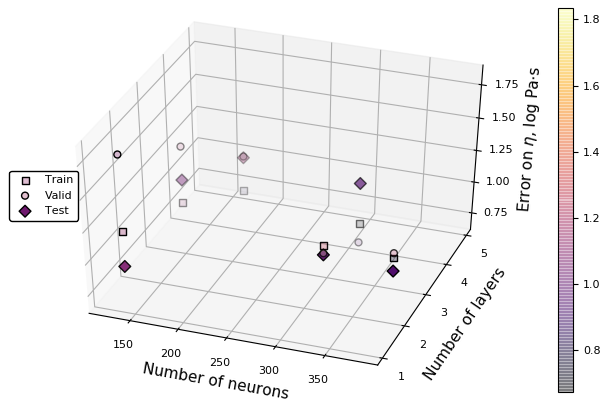

In [81]:
scatter(arch[:,1], # X
        arch[:,2], # Y
        errors_arch_train_valid_test[:,1], # Z
        zcolor=reverse(errors_arch_train_valid_test[:,1]), # Color
        m=(:square,5,0.3),
        camera = (20,40), # orientation option
        xlabel="Number of neurons",
        ylabel="Number of layers",
        zlabel=L"Error on $\eta$, log Pa$\cdot$s",
        legend=:left,
        label="Train")

scatter!(arch[:,1], # X
        arch[:,2], # Y
        errors_arch_train_valid_test[:,2], # Z
        zcolor=reverse(errors_arch_train_valid_test[:,2]),
        m=(:circle,5,0.3),
        label="Valid")

scatter!(arch[:,1], # X
        arch[:,2], # Y
        errors_arch_train_valid_test[:,3], # Z
        m=(:diamond,6),
        zcolor=reverse(errors_arch_train_valid_test[:,3]),
        label="Test")



# Entropy variations of best network(s)

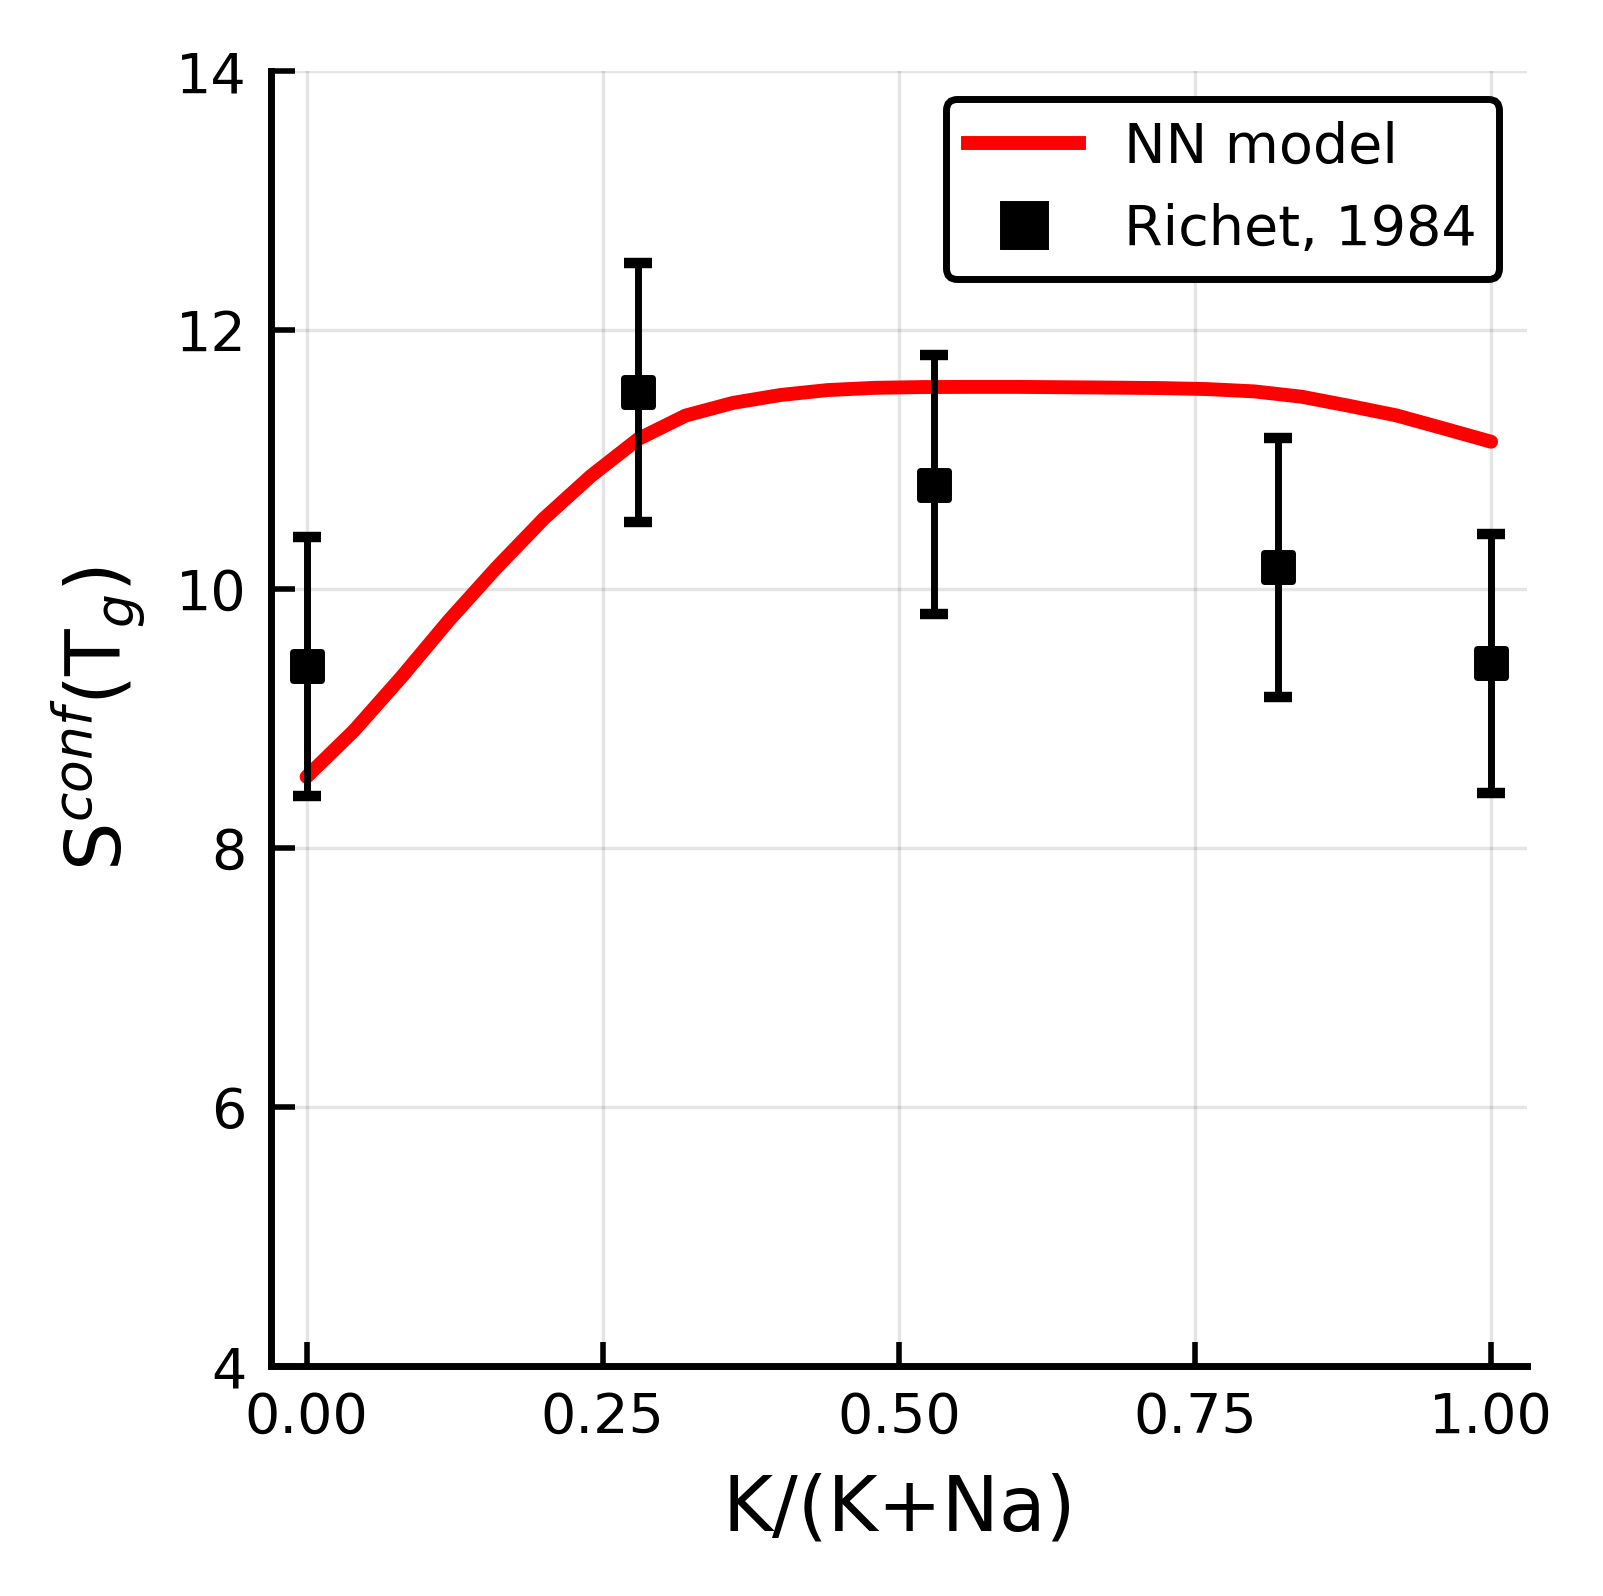

In [14]:
na2o = collect(0.:0.01:0.25)
k2o = 0.25.-na2o
sio2 = ones(size(na2o,1)).*0.75
al2o3 = zeros(size(na2o,1))
dummy = zeros(size(na2o,1))
T = ones(size(na2o,1)).*1000.0

X_visu_ = [sio2 al2o3 na2o k2o dummy dummy dummy dummy dummy T dummy dummy]'

# X_visu_NKS_sc = copy(X_visu_NKS)

# for i = 1:7
#     X_visu_NKS_sc[i,:] = (X_visu_NKS_sc[i,:].- X_scaler_mean[i])./sqrt.(X_scaler_var[i]) 
# end

plot(X_visu_[4,:]./(X_visu_[3,:].+X_visu_[4,:]),ScTg(X_visu_).data'[:],
    line=("red",2),
    xlabel="K/(K+Na)",
    ylabel=L"S$^{conf}$(T$_g$)",
    ylim=(4,14),
    label="NN model",
    size=(300,300),dpi=500)
scatter!([0,0.28,0.53,0.82,1.0],[32.91,40.31,37.81,35.59,32.99]./7.0.*2.0,
    err = 1.0,
    label="Richet, 1984",
    marker=(:square,"black",4),
    c = :black)

savefig("./figures/KNS_75_Sc.png")

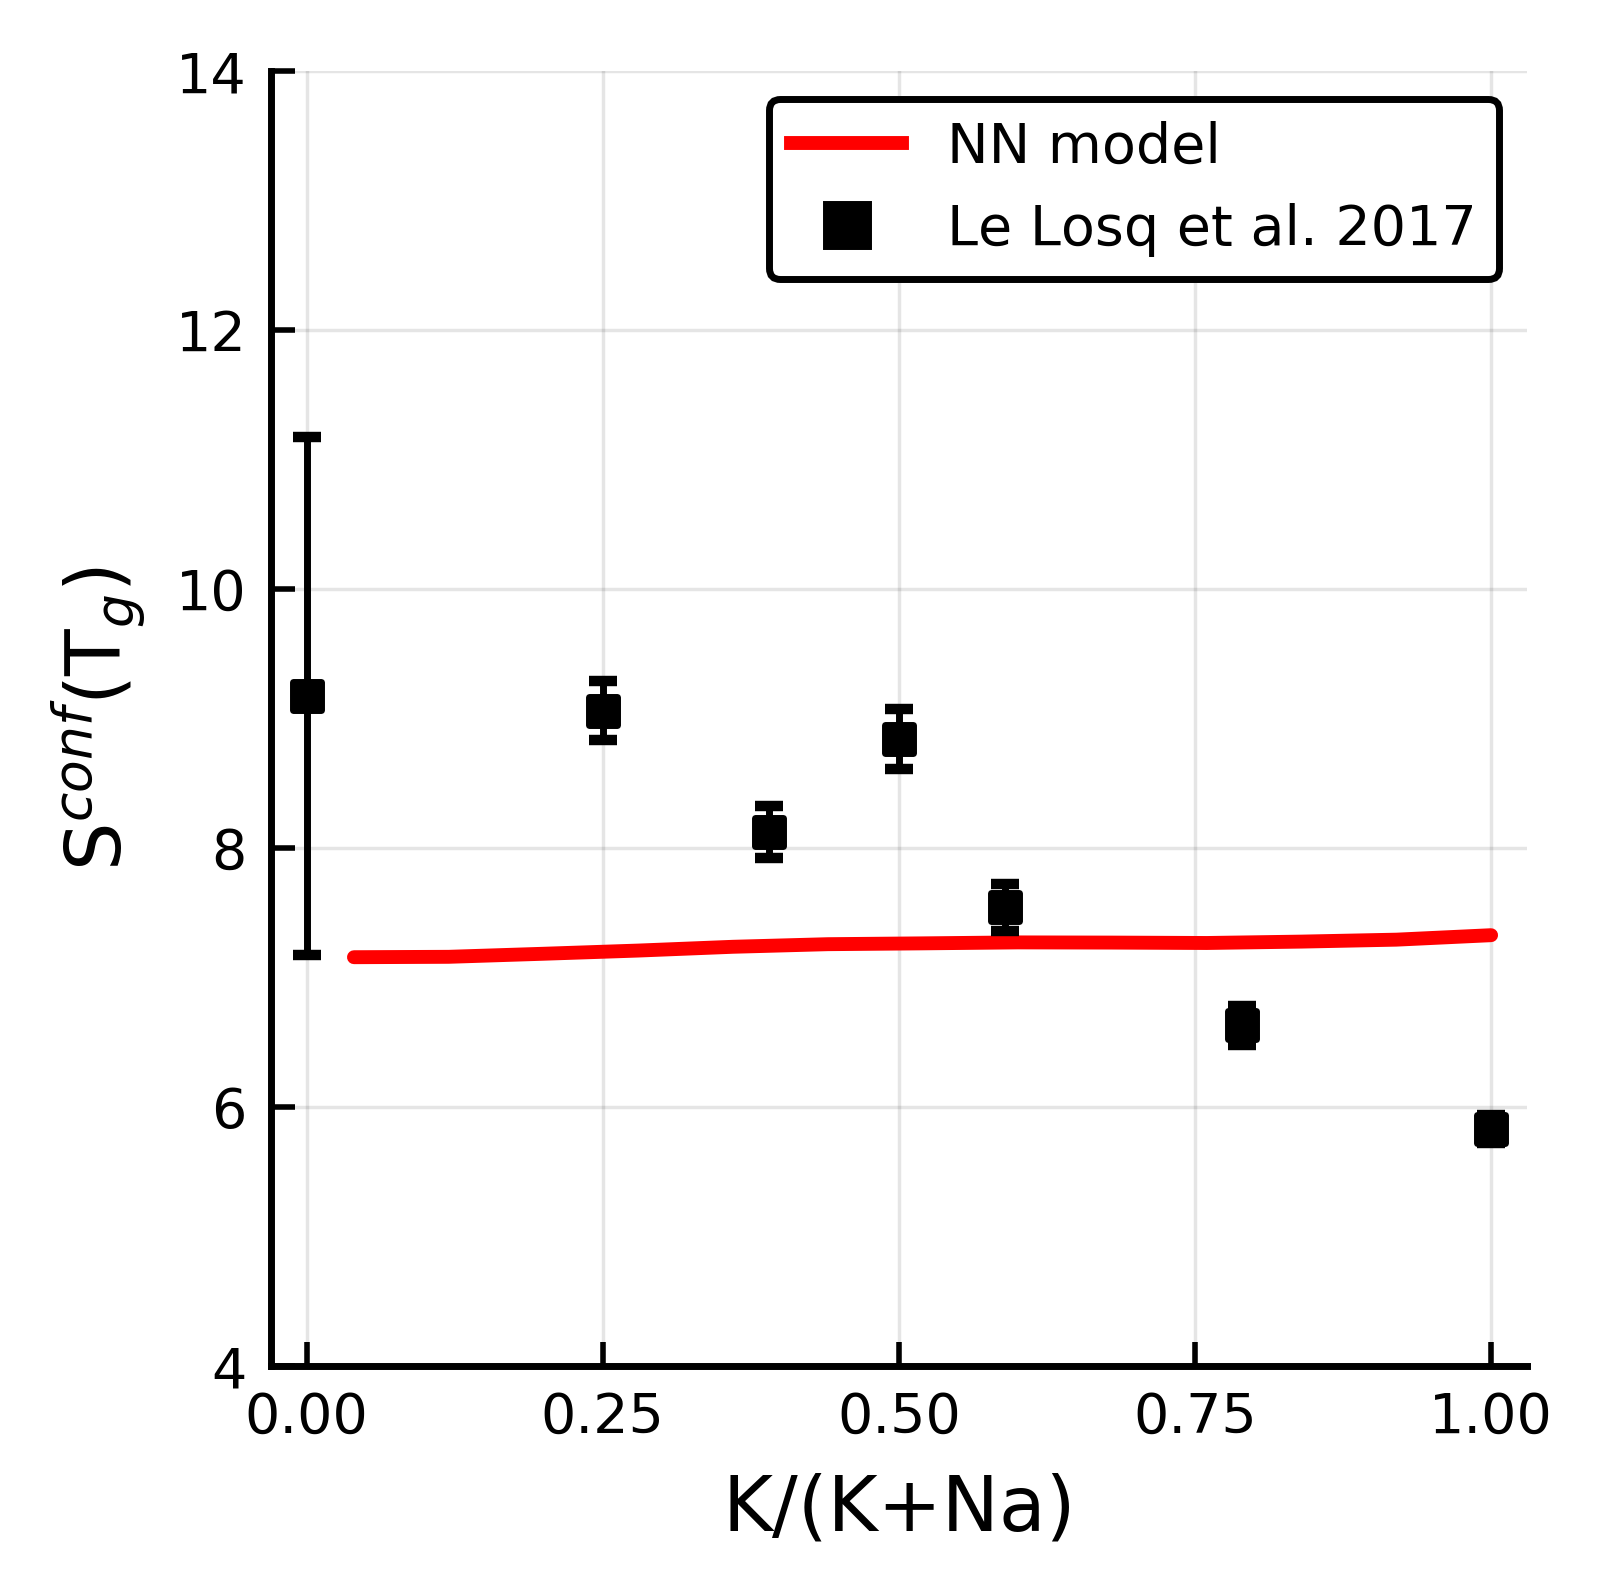

In [15]:
na2o = collect(0.:0.01:0.125)
k2o = 0.125.-na2o
sio2 = ones(size(na2o,1)).*0.75
al2o3 = ones(size(na2o,1)).*0.125
dummy = zeros(size(na2o,1))
T = ones(size(na2o,1)).*1000.0

X_visu_ = [sio2 al2o3 na2o k2o dummy dummy dummy dummy dummy T dummy dummy]'

plot(X_visu_[4,:]./(X_visu_[3,:].+X_visu_[4,:]),ScTg(X_visu_).data'[:],
    line=("red",2),
    xlabel="K/(K+Na)",
    ylabel=L"S$^{conf}$(T$_g$)",
    label="NN model",
    ylim=(4,14),
    size=(300,300),dpi=500)
scatter!([0,0.25,0.39,0.50,0.59,0.79,1.00],[9.17,9.06,8.12,8.84,7.54,6.63,5.83],
    err = [2.,0.23,0.20,0.23,0.18,0.15,0.11],
    label="Le Losq et al. 2017",
    marker=(:square,"black",4),
    c = :black)

savefig("./figures/KNAS_75_Sc.png")

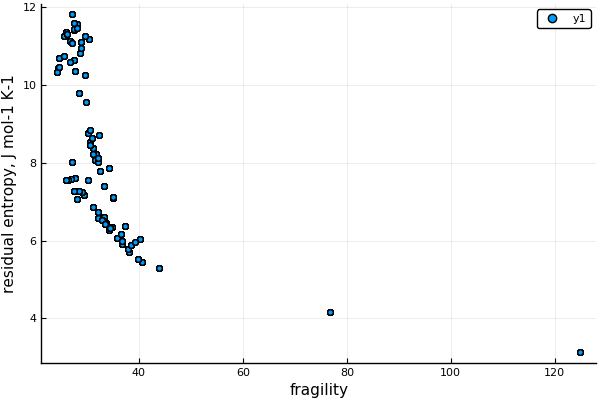

In [16]:
scatter(fragility(x_train_).data[:],ScTg(x_train_).data[:],xlabel="fragility",ylabel="residual entropy, J mol-1 K-1")



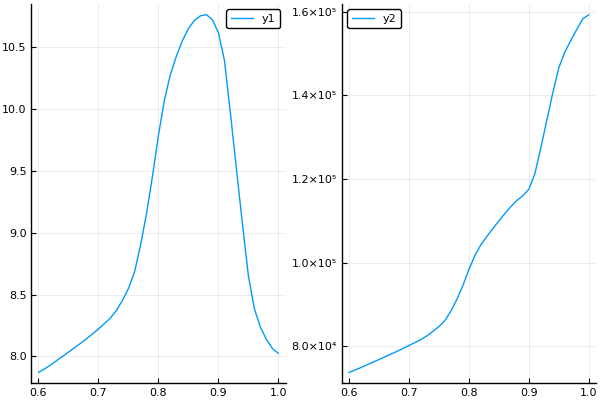

In [17]:
sio2 = collect(0.6:0.01:1.)
al2o3 = zeros(size(sio2,1))
na2o = 1.0.-sio2
k2o = zeros(size(sio2,1))
dummy = zeros(size(sio2,1))
T = ones(size(sio2,1)).*1000.0
X_visu_ = [sio2 al2o3 na2o k2o dummy dummy dummy dummy dummy T dummy dummy]'


plot([X_visu_[1,:],X_visu_[1,:]],
    [ScTg(X_visu_).data'[:],Be(X_visu_).data'[:]],
layout=2)


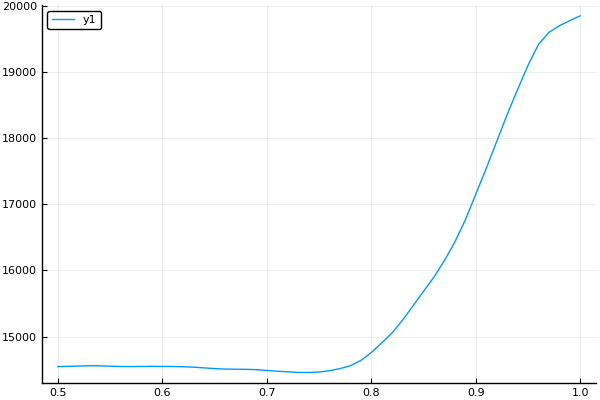

In [18]:
sio2 = collect(0.5:0.01:1.)
al2o3 = (1.0.-sio2)./2.0
na2o = copy(al2o3)
k2o = zeros(size(sio2,1))
dummy = zeros(size(sio2,1))
T = ones(size(sio2,1)).*1000.0
X_visu_ = [sio2 al2o3 na2o k2o dummy dummy dummy dummy dummy T dummy dummy]'


plot(X_visu_[1,:],
    Be(X_visu_).data'[:]./ScTg(X_visu_).data'[:],
layout=1)


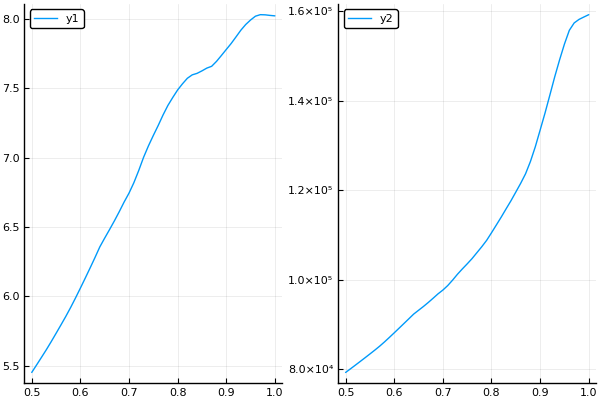

In [19]:
sio2 = collect(0.5:0.01:1.)
al2o3 = (1.0.-sio2)./2.0
na2o = copy(al2o3)
k2o = zeros(size(sio2,1))
dummy = zeros(size(sio2,1))
T = ones(size(sio2,1)).*1000.0
X_visu_ = [sio2 al2o3 na2o k2o dummy dummy dummy dummy dummy T dummy dummy]'


plot([X_visu_[1,:],X_visu_[1,:]],
    [ScTg(X_visu_).data'[:],Be(X_visu_).data'[:]],
layout=2)


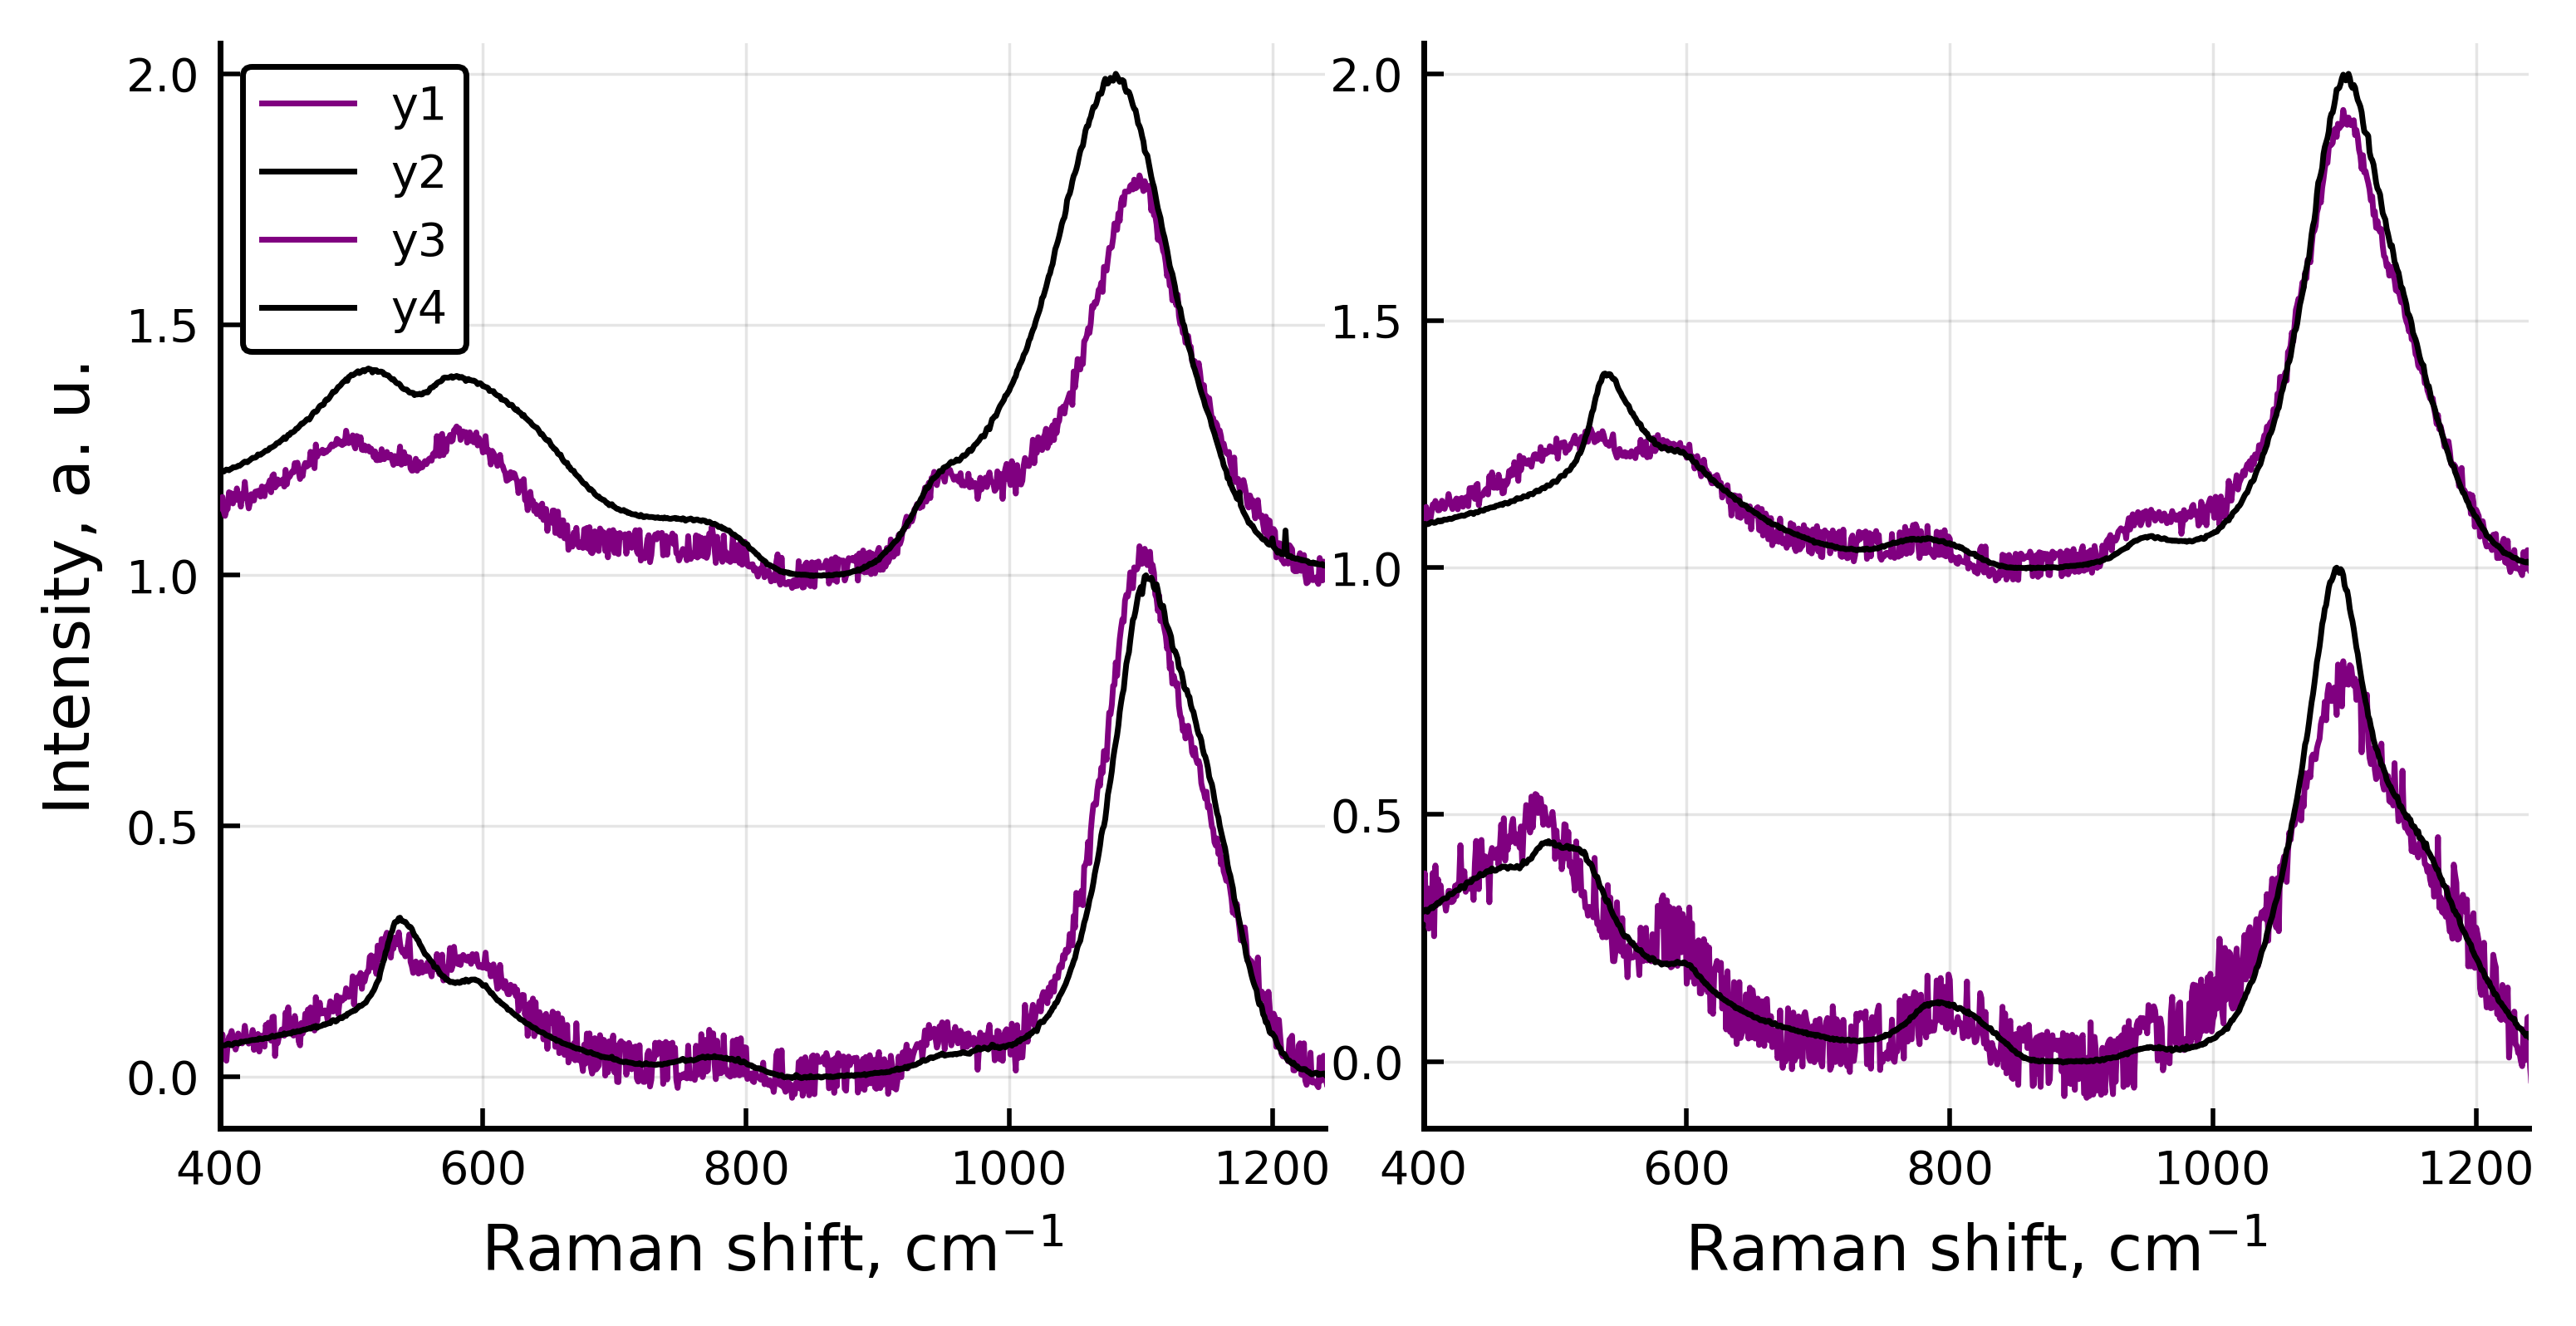

In [27]:
frequency = collect(400.:1.:1250.)

plot(frequency,mr(X_raman_valid).data[:,4], layout=2, 
    xlabel=L"Raman shift, cm$^{-1}$", ylabel="Intensity, a. u.",
    color=:purple,
    xlim=(400,1240),
    size=(600,300),dpi=500)

plot!(frequency,y_raman_valid[:,4],color=:black)

plot!(frequency,mr(X_raman_valid).data[:,10].+1.,color=:purple)
plot!(frequency,y_raman_valid[:,10].+1.,color=:black)

plot!(frequency,mr(X_raman_valid).data[:,7],color=:purple, 
    subplot=2,xlabel=L"Raman shift, cm$^{-1}$",xlim=(400,1240),legend=false)

plot!(frequency,y_raman_valid[:,7],color=:black, subplot=2)

plot!(frequency,mr(X_raman_valid).data[:,9].+1.,color=:purple, subplot=2)
plot!(frequency,y_raman_valid[:,9].+1.,color=:black, subplot=2)
savefig("./figures/ANN_Raman_examples.png")